In [17]:
import openai
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
openai.api_key = os.getenv("OPENAI_API_KEY")
fine_tuned_model_id = "ft:gpt-4o-mini-2024-07-18:personal:realdata:AXihpSnX"

# Load the validation dataset
validation_file = "real_job_data_validation.jsonl"
output_file = "real_model_predictions.jsonl"
validation_data = []

with open(validation_file, "r") as file:
    for line in file:
        validation_data.append(json.loads(line))

# Extract the first 200 samples for evaluation
validation_data = validation_data[:200]


In [3]:
def predict_median_salary(fine_tuned_model, job_description):
    response = openai.ChatCompletion.create(
        model=fine_tuned_model,
        messages=[
            {"role": "system", "content": "You are an assistant that predicts median salaries for jobs based on their description."},
            {"role": "user", "content": job_description}
        ]
    )
    return response.choices[0].message['content'], response

predictions = []
ground_truths = []
outputs = []
job_titles = []
texts = []

for data in validation_data:
    user_message = data["messages"][1]["content"]
    true_salary = float(data["messages"][2]["content"])
    try:
        predicted_salary, response = predict_median_salary(fine_tuned_model_id, user_message)
        predicted_salary = float(predicted_salary)
        predictions.append(predicted_salary)
        ground_truths.append(true_salary)
        
        job_title = user_message.split('\n')[0]
        job_titles.append(job_title)
        texts.append(user_message)
        
        output_entry = {
            "input": user_message,
            "true_salary": true_salary,
            "predicted_salary": predicted_salary,
            "job_title": job_title,
            "model_response": response.to_dict()
        }
        outputs.append(output_entry)
    except Exception as e:
        print(f"Prediction failed for data: {data}, Error: {e}")

# Save predictions
with open(output_file, "w") as file:
    for entry in outputs:
        file.write(json.dumps(entry) + "\n")

In [4]:
# Basic Metrics

mae = mean_absolute_error(ground_truths, predictions)
mse = mean_squared_error(ground_truths, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(ground_truths, predictions)
mape = np.mean(np.abs((np.array(ground_truths) - np.array(predictions)) / np.array(ground_truths))) * 100

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.3f}")


Model Performance Metrics:
Mean Absolute Error (MAE): $8,112.31
Root Mean Squared Error (RMSE): $20,158.36
Mean Absolute Percentage Error (MAPE): 8.10%
R² Score: 0.866


In [5]:
results_df = pd.DataFrame({
    'Job Title': job_titles,
    'Texts': texts,
    'True Salary': ground_truths,
    'Predicted Salary': predictions,
    'Absolute Error': np.abs(np.array(ground_truths) - np.array(predictions)),
    'Percentage Error': np.abs((np.array(ground_truths) - np.array(predictions)) / np.array(ground_truths)) * 100
})


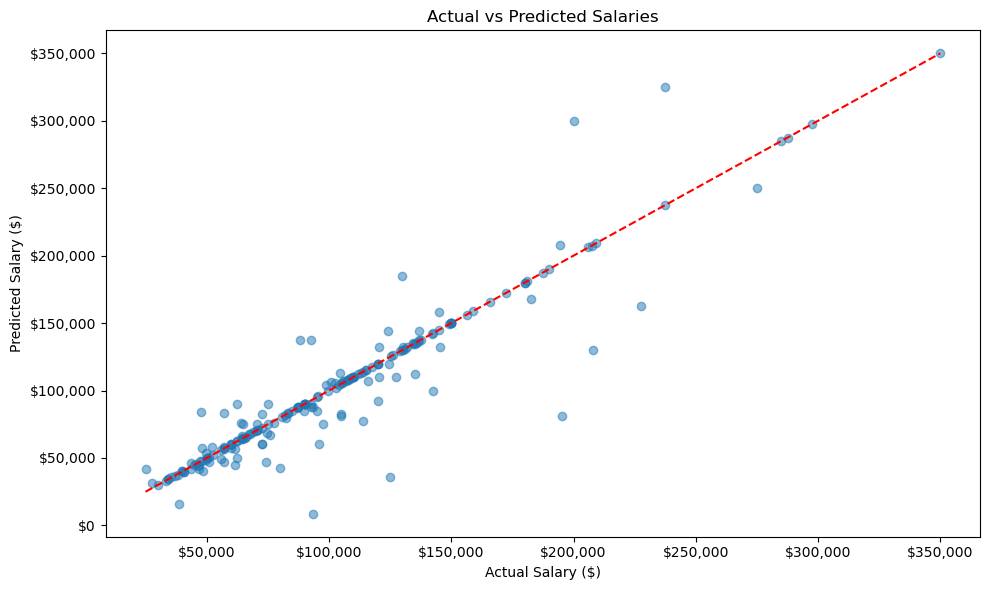

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(ground_truths, predictions, alpha=0.5)
plt.plot([min(ground_truths), max(ground_truths)], [min(ground_truths), max(ground_truths)], 'r--')
plt.xlabel('Actual Salary ($)')
plt.ylabel('Predicted Salary ($)')
plt.title('Actual vs Predicted Salaries')

# Add formatting to axis labels
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.tight_layout()
plt.show()


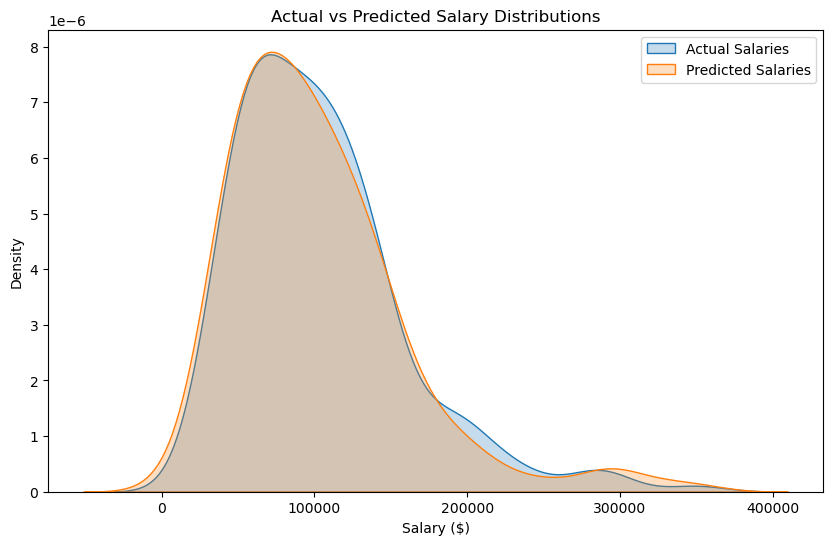

In [7]:
# Compare the actual and predicted salary distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(ground_truths, label='Actual Salaries', fill=True)
sns.kdeplot(predictions, label='Predicted Salaries', fill=True)
plt.xlabel('Salary ($)')
plt.ylabel('Density')
plt.title('Actual vs Predicted Salary Distributions')
plt.legend()



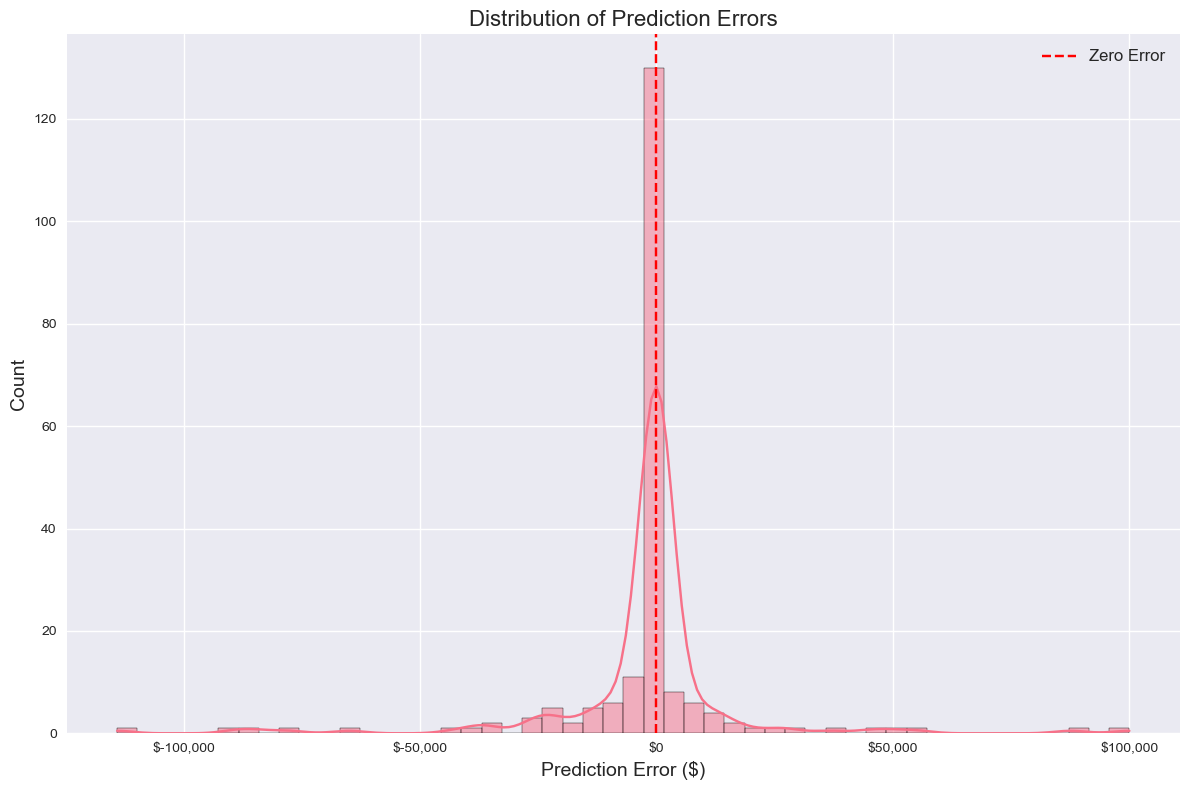

In [16]:
# Error Distribution
plt.figure(figsize=(12, 8))
errors = np.array(predictions) - np.array(ground_truths)

# Adjust bin size and KDE bandwidth
sns.histplot(errors, bins=50, kde=True, kde_kws={"bw_adjust": 0.5})

plt.xlabel('Prediction Error ($)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.legend(fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



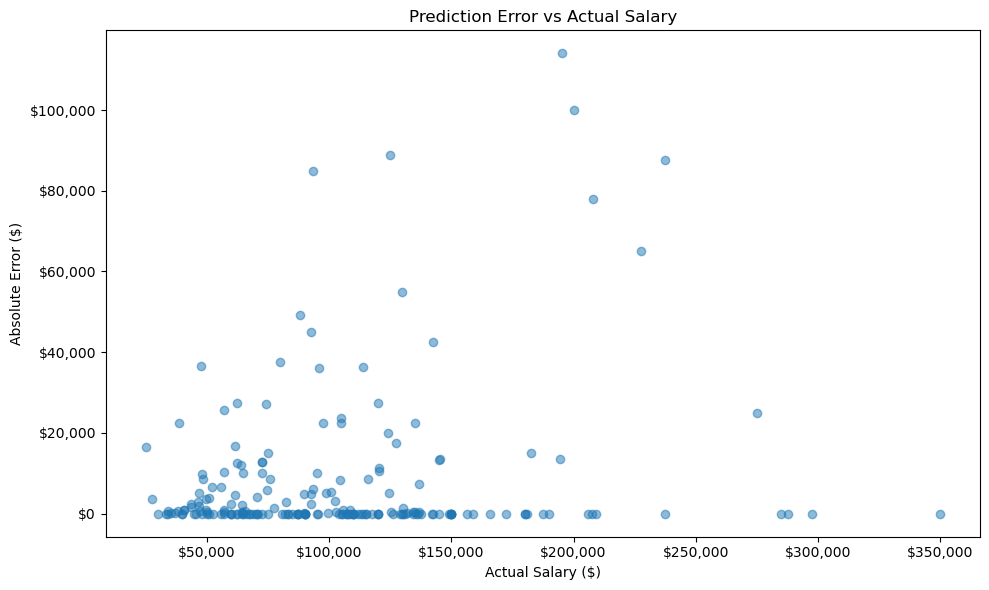

In [9]:
# Error Distribution by Salary Range
plt.figure(figsize=(10, 6))
plt.scatter(ground_truths, np.abs(errors), alpha=0.5)
plt.xlabel('Actual Salary ($)')
plt.ylabel('Absolute Error ($)')
plt.title('Prediction Error vs Actual Salary')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.tight_layout()
plt.show()


In [10]:
performance_summary = results_df.sort_values('Absolute Error', ascending=False)[:10]
print("\nTop 10 Predictions with Highest Absolute Error:")
print(performance_summary.to_string(index=False, float_format=lambda x: f"${x:,.2f}" if x > 100 else f"{x:.2f}%"))



Top 10 Predictions with Highest Absolute Error:
                                                                         Job Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     